# Μετατροπή μετρήσεων

Θα μελετήσουμε τον τρόπο με τον οποίο θα μετατρέψουμε τις μετρήσεις στους αντίστοιχους φακέλους. Συγκεκριμένα, θέλουμε κάθε RFID tag να έχει συντεταγμένες ως προς το επιλεγμένο $(0,0)$, και κάθε καμπύλη να έχει μεταφερθεί στο $(0,0)$

****

Θέλουμε να μετατρέψουμε κάθε φάκελο μετρήσεων. Σε κάθε διαδρομή (πείραμα) θα επιλέξουμε την κεραία με τα περισσότερα δείγματα για ένα tag και θα την μεταφέρουμε στο $(0,0)$.

Με βάση την μετατροπή αυτής της τροχιάς θα μετατρέψουμε τις συντεταγμένες του tag στον φάκελο ```Transformed_Coordinates.xlsx``` κρατώντας και τις αρχικές συντεταγμένες για ευκολία.

Για το ίδιο tag, πιθανόν να υπάρχουν και άλλες κεραίες που θα το έχουν διαβάσει. Οι τροχιές που θα έχουν δημιουργηθεί από αυτές (τις κεραίες) θα μετατοπιστούν με βάση τις συντεταγμένες της κεραίας με τα περισσότερα δείγματα.

***

## Συνάρτηση στροφής

Η συνάρτηση στροφής που θα χρησιμοποιηθεί είναι η παρακάτω και η διαδικασία έχει ήδη περιγραφεί σε προηγούμενο notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
import pickle

In [19]:
def rotate_points_to_zero(x, y, rfid_pos):
    # Subtract the starting point from all the points
    y_new = y - y[0]
    x_new = x - x[0]

    rfid_new = np.array([rfid_pos[0] - x[0], rfid_pos[1] - y[0]])

    # Calculate the angle
    angle = np.arctan2(y_new[-1], x_new[-1])

    # Create the rotation matrix
    rotation_matrix = np.array([[np.cos(angle), np.sin(angle)],
                                [-np.sin(angle), np.cos(angle)]])

    # Rotate all the points
    rotated_points = np.dot(rotation_matrix, np.vstack((x_new, y_new)))
    x_rot, y_rot = rotated_points[0], rotated_points[1]

    # Replace very small values with 0
    x_rot = np.where(np.abs(x_rot) < 1e-10, 0, x_rot)
    y_rot = np.where(np.abs(y_rot) < 1e-10, 0, y_rot)

    # Rotate the RFID Tag
    rfid_rot = np.dot(rotation_matrix, rfid_new)

    # Check if the RFID Tag is in the negative y-axis, then move everything to the positive y-axis
    if rfid_rot[1] < 0:
        y_rot = -y_rot
        rfid_rot[1] = -rfid_rot[1]

    return x_rot, y_rot, rfid_rot, angle

Ορίζουμε και μία δεύτερη συνάρτηση στροφής που θα χρησιμοποιηθεί για να μεταφέρει τις υπόλοιπες τροχιές στο ίδιο σύστημα συντεταγμένων με την αρχική.

Λαμβάνει σαν όρισμα τα αρχικά σημεία της επιλεγμένης τροχιάς και την γωνία στροφής και έπειτα μεταφέρει την τροχιά στο ζητούμενο σύστημα συντεταγμένων.

In [20]:
def rotate_with_respect(x_start, y_start, angle, x, y):
    # Create the rotation matrix
    rotation_matrix = np.array([[np.cos(angle), np.sin(angle)],
                                [-np.sin(angle), np.cos(angle)]])

    # Subtract the starting point from all the points
    y_new = y - y_start
    x_new = x - x_start

    # Rotate all the points
    rotated_points = np.dot(rotation_matrix, np.vstack((x_new, y_new)))
    x_rot, y_rot = rotated_points[0], rotated_points[1]

    # Replace very small values with 0
    x_rot = np.where(np.abs(x_rot) < 1e-10, 0, x_rot)
    y_rot = np.where(np.abs(y_rot) < 1e-10, 0, y_rot)

    return x_rot, y_rot

***

## Μετατροπή των υποφάκελων μετρήσεων

**!!!! ΔΕΝ ΧΡΕΙΑΖΕΤΑΙ ΝΑ ΤΡΕΞΕΙ ΑΛΛΟ !!!!**

Θα υλοποιήσουμε την διαδικασία που περιγράφεται παραπάνω.

Ανφέρουμε ξανά και πιο λεπτομερώς την διαδικασία που θα ακολουθήσουμε.
- Διαβάζουμε τον κεντρικό φάκελο με όλες τις μετρήσεις.
- Επαναληπτικά για όλα τα πειράματα εντοπίζουμε τον φάκελο ```Transformed_Coordinates.xlsx``` που βρίσκεται στο **εξωτερικό** επίπεδο και όχι αυτόν που είναι φωλιασμένος στους φακέλους των κεραιών.
- Για συγκεκριμένο πείραμα, επαναληπτικά εντοπίζουμε κάθε tag που αναγράφεται στον προαναφερθέντα φάκελο, και βρίσκουμε την τροχιά με τα περισσότερα samples (μεγαλύτερο μέγεθος) από τις (μέχρι) 4 κεραίες.
- Η τροχιά αυτή στρέφεται στον θετικό ημιάξονα Χ και μεταφέρεται στο $(0,0)$.
- Με βάση αυτή την τροχιά στρέφεται και το αντίστοιχο RFID tag.
- Οι υπόλοιπες τροχιές που βρίσκονται στις άλλες τρεις κεραίες στρέφονται και μετατοπίζονται με βάση την αρχική τροχιά.


In [23]:
# Root folder where all the files are stored
root_folder = Path(__file__).parent if "__file__" in globals() else Path.cwd()
root_folder /= 'Measurements'

# Loop through all directories and files
for folder_path, _, files in os.walk(root_folder):
    if 'Antenna_' not in folder_path: # It means we are on the top-most subfolder, we don't want to edit the nested "Transformed_Coordinates" files
        file_tag = os.path.join(folder_path, 'Transformed_Coordinates.xlsx')

        # Check if the file exists
        try:
            rfid_df = pd.read_excel(file_tag)
        except FileNotFoundError:
            continue
        
        # All of the folders we expect to iterate through
        folders = ['Antenna_1', 'Antenna_2', 'Antenna_3', 'Antenna_4']

        # Extract each tag name from the rfid_df
        for tag in rfid_df['EPC_TAG'].unique():
            # Get the rfid tag coordinates
            row = rfid_df[rfid_df["EPC_TAG"] == tag]
            rfid_x = row["X"].values[0] 
            rfid_y = row["Y"].values[0]

            # Initialize variables to find the largest file in size
            largest_file = None
            largest_size = -1

            # Iterate through all antenna folders, if they exist, and locate the largest file path for each tag
            for folder in folders:
                antenna_folder = os.path.join(folder_path, folder)
                fol1_folder = os.path.join(antenna_folder, 'unwrapped_measurements')

                #for search_folder in [antenna_folder, fol1_folder]:
                if os.path.exists(fol1_folder):
                    for file in os.listdir(fol1_folder):
                        if file == f"{tag}.txt":
                            file_path = os.path.join(fol1_folder, file)
                            file_size = os.path.getsize(file_path)
                            if file_size > largest_size:
                                largest_size = file_size
                                largest_file = file_path
            
            # Since we found the largest file, we transform it using the "rotate_points_to_zero" function.
            # Then we also save the data to a new excel file, and also store the coordinates of the rotated RFID tag.
            if largest_file:
                df = pd.read_csv(largest_file, header = None, names = ['time', 'X', 'Y', 'Z', 'Power', 'Phase', 'Phase_Unwrapped'])

                # Extract as arrays
                X = df["X"].values
                Y = df["Y"].values

                # Rotate and transform the points to (0,0)
                X_rot,Y_rot, rfid_pos, rot_angle = rotate_points_to_zero(X, Y, [rfid_x * 100,rfid_y * 100]) 
                
                # Save the new data
                df["X_new"] = X_rot
                df["Y_new"] = Y_rot

                rfid_df.loc[rfid_df["EPC_TAG"] == tag, "X_new"] = rfid_pos[0]
                rfid_df.loc[rfid_df["EPC_TAG"] == tag, "Y_new"] = rfid_pos[1]
                
                rfid_df.to_excel(file_tag, index = False)

                new_file_path = largest_file.replace(".txt", "_processed.xlsx")
                df.to_excel(new_file_path, index = False)
            
            # Now we need to rotate the other orbits with respect to the initial one (the largest in size)
            # We once more iterate through all the "Antenna" folders in order to locate all instances of the tag.
            for folder in folders:    
                antenna_folder = os.path.join(folder_path, folder)
                fol1_folder = os.path.join(antenna_folder, 'unwrapped_measurements')

                # Check if file exists, and if it does also check if file has already been processed.
                if os.path.exists(fol1_folder):
                    if f"{tag}_processed.xlsx" in os.listdir(fol1_folder):
                        continue
                    else:
                        # The following procedure is simillar to the one before, but instead of rotating the orbit to zero, we rotate it with respect to the largest orbit.
                        for file in os.listdir(fol1_folder):
                            if file == f"{tag}.txt":
                                file_path = os.path.join(fol1_folder, file)
                                df_1 = pd.read_csv(file_path, header = None, names = ['time', 'X', 'Y', 'Z', 'Power', 'Phase', 'Phase_Unwrapped'])

                                # Extract as arrays
                                X1 = df_1["X"].values
                                Y1 = df_1["Y"].values

                                # Rotate and transform the points to (0,0)
                                X_rot, Y_rot = rotate_with_respect(X[0], Y[0], rot_angle, X1, Y1)
                                
                                # Save the new data
                                df_1["X_new"] = X_rot
                                df_1["Y_new"] = Y_rot

                                new_file_path = file_path.replace(".txt", "_processed_smaller.xlsx")
                                df_1.to_excel(new_file_path, index = False)

#We expect to see 2 types of folders inside the unwrapped measurements folders. The larger in size will have the '_processed.xlsx' suffix, while the smaller ones will have the 
#'_processed_smaller.xlsx'.        


KeyboardInterrupt: 

***

## Screenshot για απόδειξη

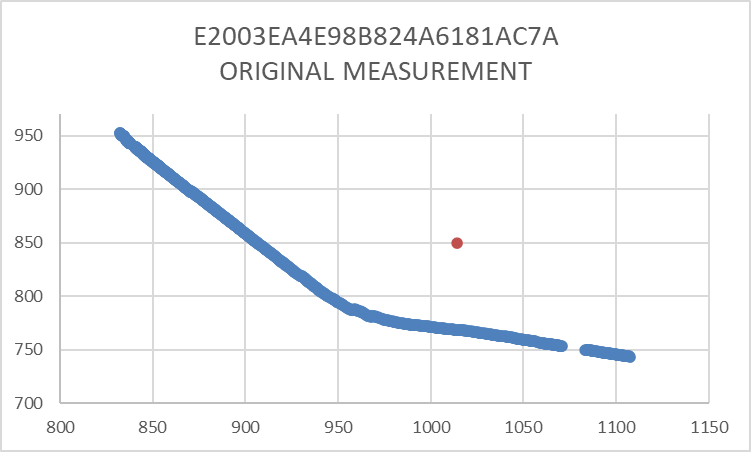

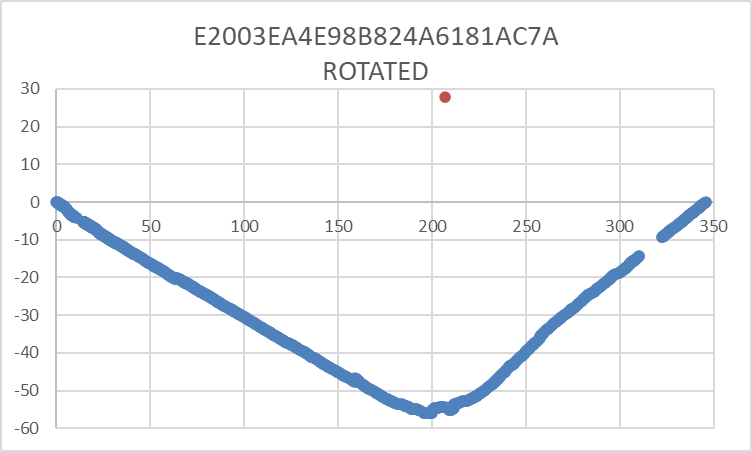

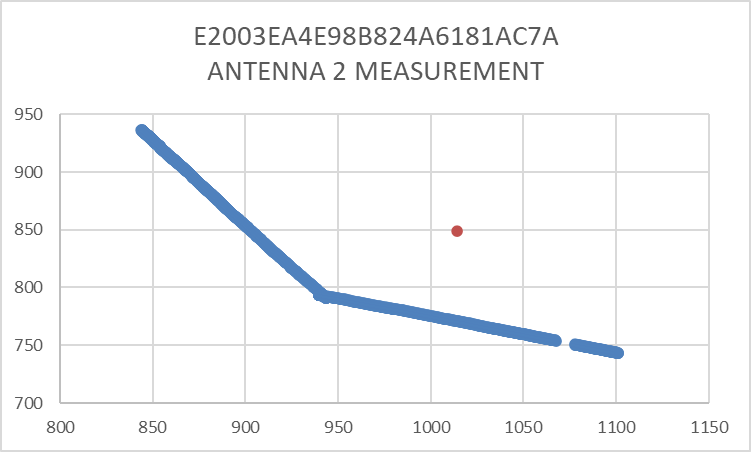

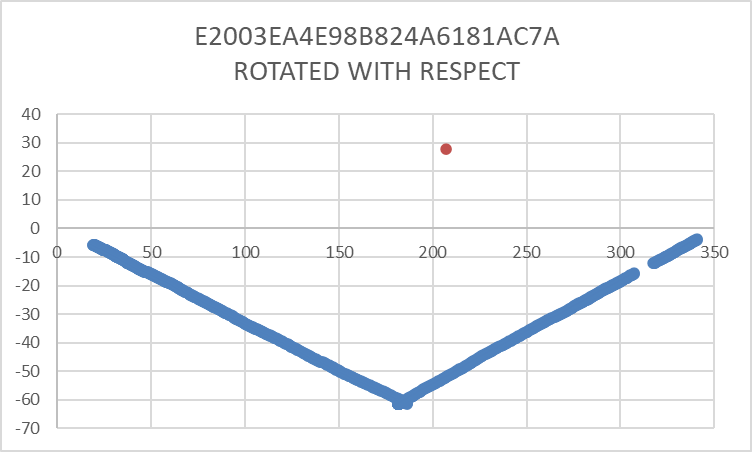

***

## Προετοιμασία των δεδομένων

Πλέον έχουμε μετατρέψει όλους τους υποφακέλους στην μορφή που τους θέλουμε, στραμένους στο 0. Τώρα θα δημιουργήσουμε τους πίνακες X και y για εισαγωγή στο νευρωνικό.

Για αρχή ασχολούμαστε με το straight path.

Η παρακάτω συνάρτηση θα χρησιμοποιηθεί για να κάνει γραμμική παρεμβολή στα data, τα οποία θα έχουν την μορφή [X,Y,Z,phase].

In [21]:
def lin_interpolation(data, length):
    x_original = np.linspace(0, 1, len(data))
    x_new = np.linspace(0, 1, length)    

    # Initialize the result array
    result = np.empty((length, data.shape[1]))

    # Interpolate each column
    for i in range(data.shape[1]):
        interp_func = np.interp(x_new, x_original, data[:, i])
        result[:, i] = interp_func

    return result

In [ ]:
# Root folder where all the files are stored
root_folder = Path(__file__).parent if "__file__" in globals() else Path.cwd()
root_folder /= 'Measurements'

experinent = 'Straight ' # Some are named Straight Path, some Straight path.....................................

size_threshold = 10240  #10KB in our case, anything smaller in size will get filtered out

interp_length = 500 # Large enough to not clip information from bigger files, and small enought to not destroy small files, need to check what works best

final_tensor = []
final_labels = []

# Loop through all directories and files
for folder_path, _, files in os.walk(root_folder):
    # We only examine the folders with a specific experiment, in our case Straight Path
    if experinent not in folder_path:
        continue

    if 'Antenna_' not in folder_path: # It means we are on the top-most subfolder, we don't want to read the nested 'Transformed_Coordinates' since the outer one is edited.
        file_tag = os.path.join(folder_path, 'Transformed_Coordinates.xlsx')

        # Check if the file exists
        try:
            rfid_df = pd.read_excel(file_tag)
        except FileNotFoundError:
            continue
        
        # All of the folders we expect to iterate through
        folders = ['Antenna_1', 'Antenna_2', 'Antenna_3', 'Antenna_4']

        # All of the columns we need to save
        sel_cols = ['X_new', 'Y_new', 'Z', 'Phase_Unwrapped']

        # Extract each tag name from the rfid_df
        for tag in rfid_df['EPC_TAG'].unique():
            # Get the rfid tag coordinates
            row = rfid_df[rfid_df["EPC_TAG"] == tag]
            rfid_x = row["X_new"].values[0] 
            rfid_y = row["Y_new"].values[0]
            rfid_z = row['Z'].values[0] * 100 # Z was in meters

            # Iterate through all antenna folders, if they exist, and locate the excel file path for each tag
            for folder in folders:
                # Go inside the unwrapped measurements folder to search for the processed excel file
                antenna_folder = os.path.join(folder_path, folder)
                unwrapped_measurement_fold = os.path.join(antenna_folder, 'unwrapped_measurements')

                if os.path.exists(unwrapped_measurement_fold): # If it exists continue
                    for file in os.listdir(unwrapped_measurement_fold): # For all files in the unwrapped measurements directory search for the one excel file that has our current tag name
                        if file == f"{tag}_processed.xlsx" or file == f"{tag}_processed_smaller.xlsx":
                            # Create the file path for current tag
                            file_path = os.path.join(unwrapped_measurement_fold, file)

                            # If the file is smaller than a threshold do not save it since it is trash
                            if os.path.getsize(file_path) >= size_threshold:
                                tag_df = pd.read_excel(file_path)

                                # Create the tensor containing all our information [X,Y,Z,phase]
                                info_tens = tag_df[sel_cols].to_numpy()

                                # Interpolate to create a specific length tensor not an arbitary one
                                res = lin_interpolation(info_tens, interp_length)

                                # Append result and tag to their respective array
                                final_tensor.append(res)
                                final_labels.append([rfid_x, rfid_y, rfid_z])

Εφόσον έχουμε τους πίνακες με τα δεδομένα μας τους μετατρέπουμε σε numpy πίνακες.

In [ ]:
final_labels = np.array(final_labels)
final_tensor = np.array(final_tensor)

final_labels.shape , final_tensor.shape # final_labels shape (tags_measured, (x_tag,y_tag,z_tag)), final_tensor shape (tags_measured, fixed_sample_size, (x_rob,y_rob,z_rob, phase))

((1013, 3), (1013, 500, 4))

Τέλος αποθηκεύουμε τα δεδομένα σε έναν νέο φάκελο Raw_Data, με την μορφή .npy .

In [ ]:
from pathlib import Path

# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

# Initialize a list to store the indices
existing_indices = []

# Iterate through the folders in the directory
for folder in parent_dir.iterdir():
    if folder.is_dir() and folder.name.startswith("Raw_Data_Single_Antenna"):  # Check if it's a directory and follows the pattern
        try:
            index = int(folder.name[len("Raw_Data_Single_Antenna"):])  # Extract the number part
            existing_indices.append(index)
        except ValueError:
            pass  # Ignore folders that don't have a valid integer index

# Determine the next index
new_index = (max(existing_indices) + 1) if existing_indices else 0

# Create the new folder
new_folder_path = parent_dir / f"Raw_Data_Single_Antenna_{new_index}"
new_folder_path.mkdir(exist_ok=True)

print(f"Created folder: {new_folder_path}")

np.save(f"{new_folder_path}/final_tensor.npy", final_tensor)
np.save(f"{new_folder_path}/final_labels.npy", final_labels)

Created folder: c:\Users\giama\Desktop\ece_auth\semester10\NNs-on-RFID-Localization\Experiments\Raw_Data_Single_Antenna_0


Το ίδιο με πάνω αλλα για double antenna αυτη τη φορά

In [28]:
# Root folder where all the files are stored
root_folder = Path(__file__).parent if "__file__" in globals() else Path.cwd()
root_folder /= 'Measurements'

experinent = 'Straight ' # Some are named Straight Path, some Straight path.....................................

size_threshold = 10240  #10KB in our case, anything smaller in size will get filtered out

interp_length = 500 # Large enough to not clip information from bigger files, and small enought to not destroy small files, need to check what works best

final_tensor = []
final_labels = []

# Loop through all directories and files
for folder_path, _, files in os.walk(root_folder):
    # We only examine the folders with a specific experiment, in our case Straight Path
    if experinent not in folder_path:
        continue

    if 'Antenna_' not in folder_path: # It means we are on the top-most subfolder, we don't want to read the nested 'Transformed_Coordinates' since the outer one is edited.
        file_tag = os.path.join(folder_path, 'Transformed_Coordinates.xlsx')

        # Check if the file exists
        try:
            rfid_df = pd.read_excel(file_tag)
        except FileNotFoundError:
            continue
        
        # All of the folders we expect to iterate through
        folders = ['Antenna_1', 'Antenna_2', 'Antenna_3', 'Antenna_4']

        # All of the columns we need to save
        sel_cols = ['X_new', 'Y_new', 'Z', 'Phase_Unwrapped']

        # Extract each tag name from the rfid_df
        for tag in rfid_df['EPC_TAG'].unique():
            # Get the rfid tag coordinates
            row = rfid_df[rfid_df["EPC_TAG"] == tag]
            rfid_x = row["X_new"].values[0].item()
            rfid_y = row["Y_new"].values[0].item()
            rfid_z = row['Z'].values[0].item() * 100 # Z was in meters

            # Iterate through all antenna folders, if they exist, and locate the excel file path for each tag
            antenna_data_for_curr_tag = []
            antenna_num = 0
            for folder in folders:
                # Go inside the unwrapped measurements folder to search for the processed excel file
                antenna_folder = os.path.join(folder_path, folder)
                unwrapped_measurement_fold = os.path.join(antenna_folder, 'unwrapped_measurements')

                if os.path.exists(unwrapped_measurement_fold): # If it exists continue
                    antenna_num = antenna_num + 1
                    #print(f"folder {unwrapped_measurement_fold} exists")
                    for file in os.listdir(unwrapped_measurement_fold): # For all files in the unwrapped measurements directory search for the one excel file that has our current tag name
                        if file == f"{tag}_processed.xlsx" or file == f"{tag}_processed_smaller.xlsx":
                            # Create the file path for current tag
                            file_path = os.path.join(unwrapped_measurement_fold, file)

                            # If the file is smaller than a threshold do not save it since it is trash
                            if os.path.getsize(file_path) >= size_threshold:
                                tag_df = pd.read_excel(file_path)

                                # Create the tensor containing all our information [X,Y,Z,phase]
                                info_tens = tag_df[sel_cols].to_numpy()

                                # Interpolate to create a specific length tensor not an arbitary one
                                res = lin_interpolation(info_tens, interp_length)

                                antenna_data_for_curr_tag.append({'Antenna':antenna_num,'path':res,'tag_name':tag,'tag_pos':[rfid_x, rfid_y, rfid_z]})
            final_tensor.append(antenna_data_for_curr_tag)
print(final_tensor)

[[{'Antenna': 1, 'path': array([[ 29.56580882,  10.60700192,  63.3       ,   5.71868031],
       [ 29.69291086,  10.61055299,  63.3       ,   5.64897194],
       [ 29.78663339,  10.61317857,  63.3       ,   5.56121213],
       ...,
       [194.23334983,  11.5058089 ,  63.3       ,   5.98069321],
       [194.86477622,  11.49493213,  63.3       ,   6.02459098],
       [194.50851982,  12.48229196,  63.3       ,   6.27091351]]), 'tag_name': 'E2003EA4E98B6D4A6181AC26', 'tag_pos': [117.8175660100024, 74.67164218953306, 8.9]}, {'Antenna': 2, 'path': array([[ 0.00000000e+00,  0.00000000e+00,  1.07300000e+02,
         3.32567531e+00],
       [ 1.94456306e-01, -3.62104164e-03,  1.07300000e+02,
         3.38344859e+00],
       [ 3.68546431e-01, -6.86283721e-03,  1.07300000e+02,
         3.33180531e+00],
       ...,
       [ 1.90331540e+02, -7.75978260e-05,  1.07300000e+02,
        -2.82960365e+00],
       [ 1.91119836e+02, -1.58950963e-03,  1.07300000e+02,
        -2.73662000e+00],
       [ 1.920

In [36]:
from pathlib import Path

# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

# Initialize a list to store the indices
existing_indices = []

# Iterate through the folders in the directory
for folder in parent_dir.iterdir():
    if folder.is_dir() and folder.name.startswith("Raw_Data_Double_Antenna"):  # Check if it's a directory and follows the pattern
        try:
            index = int(folder.name[len("Raw_Data_Double_Antenna"):])  # Extract the number part
            existing_indices.append(index)
        except ValueError:
            pass  # Ignore folders that don't have a valid integer index

# Determine the next index
new_index = (max(existing_indices) + 1) if existing_indices else 0

# Create the new folder
new_folder_path = parent_dir / f"Raw_Data_Double_Antenna_{new_index}"
new_folder_path.mkdir(exist_ok=True)

print(f"Created folder: {new_folder_path}")

with open(os.path.join(new_folder_path,"data.pkl"),'wb') as f:
    pickle.dump(final_tensor,f)



Created folder: c:\Users\giama\Desktop\ece_auth\semester10\NNs-on-RFID-Localization\Experiments\Raw_Data_Double_Antenna_0


In [4]:
from pathlib import Path
from itertools import permutations

# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

new_folder_path = parent_dir / f"Raw_Data_Double_Antenna_0" #change number accordingly

pkl_file_path = new_folder_path / 'data.pkl'

# Load the .pkl file
with open(pkl_file_path, "rb") as file:
    data = pickle.load(file)


all_permutations = []
for sublist in data:
    sublist_permutations = list(permutations(sublist,2))
    all_permutations.append(sublist_permutations)


interp_length = 500 #SOS : Change this to the correct value
dataset = []
label_list = []
for perms in all_permutations:
    for perm in perms:
        connected_paths = []
        for i in range(len(perm)):
            connected_paths.append(perm[i]['path'])
        if(connected_paths!=[]):
            paths = np.hstack(connected_paths)
            dataset.append(paths)
            label_list.append(perm[0]['tag_pos'])

np.save(f"{new_folder_path}/final_tensor.npy", np.array(dataset))
np.save(f"{new_folder_path}/final_labels.npy", np.array(label_list))



all_permutations = []
for i,sublist in enumerate(data):
    sublist_permutations = list(permutations(sublist,2))
    all_permutations.append(sublist_permutations)
    print(i)
    if(i == 280):
        break
#print(data)

pure_data = []
pure_tag = []
for i in range(20):
    temp = data[280+i]
    paths = []
    tag_posss = []
    for j in range(3):
        paths.append(temp[j]['path'])
    pure_data.append(np.hstack(paths))
    pure_tag.append(temp[0]['tag_pos'])

pure_data = np.array(pure_data)
pure_tag = np.array(pure_tag)

np.save(f"{new_folder_path}/final_tensor_2_ant_pure.npy", np.array(pure_data))
np.save(f"{new_folder_path}/final_labels_2_ant_pure.npy", np.array(pure_tag))
interp_length = 500 #SOS : Change this to the correct value
dataset = []
label_list = []
for perms in all_permutations:
    for perm in perms:
        connected_paths = []
        for i in range(len(perm)):
            connected_paths.append(perm[i]['path'])
        if(connected_paths!=[]):
            paths = np.hstack(connected_paths)
            dataset.append(paths)
            label_list.append(perm[0]['tag_pos'])

#print(dataset)
#print(len(label_list)) 
np.save(f"{new_folder_path}/final_tensor_2_ant.npy", np.array(dataset))
np.save(f"{new_folder_path}/final_labels_2_ant.npy", np.array(label_list))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [6]:
from pathlib import Path
from itertools import permutations

# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

new_folder_path = parent_dir / f"Raw_Data_Double_Antenna_0" #change number accordingly

pkl_file_path = new_folder_path / 'data.pkl'

# Load the .pkl file
with open(pkl_file_path, "rb") as file:
    data = pickle.load(file)


all_permutations = []
for sublist in data:
    sublist_permutations = list(permutations(sublist,3))
    all_permutations.append(sublist_permutations)

interp_length = 500 #SOS : Change this to the correct value
dataset = []
label_list = []
for perms in all_permutations:
    for perm in perms:
        connected_paths = []
        for i in range(len(perm)):
            connected_paths.append(perm[i]['path'])
        if(connected_paths!=[]):
            paths = np.hstack(connected_paths)
            dataset.append(paths)
            label_list.append(perm[0]['tag_pos'])

print(dataset)
print(len(label_list)) 
np.save(f"{new_folder_path}/final_tensor_3.npy", np.array(dataset))
np.save(f"{new_folder_path}/final_labels_3.npy", np.array(label_list))

[array([[ 0.00000000e+00,  0.00000000e+00,  6.33000000e+01, ...,
        -2.54877976e+00,  1.52800000e+02,  4.62341531e+00],
       [ 3.33949402e-01,  1.92572290e-03,  6.33000000e+01, ...,
        -2.56358183e+00,  1.52800000e+02,  4.61354729e+00],
       [ 6.84111607e-01,  3.47707387e-03,  6.33000000e+01, ...,
        -2.57838389e+00,  1.52800000e+02,  4.60367928e+00],
       ...,
       [ 1.99943687e+02,  7.39333931e-03,  6.33000000e+01, ...,
        -6.47432444e+00,  1.52800000e+02,  5.29792134e+00],
       [ 2.00413627e+02,  2.25386147e-03,  6.33000000e+01, ...,
        -6.47749776e+00,  1.52800000e+02,  5.30581532e+00],
       [ 2.00601239e+02,  0.00000000e+00,  6.33000000e+01, ...,
        -6.48067109e+00,  1.52800000e+02,  5.31370931e+00]]), array([[ 0.00000000e+00,  0.00000000e+00,  6.33000000e+01, ...,
         1.13835000e+00,  1.92800000e+02,  2.50345531e+00],
       [ 3.33949402e-01,  1.92572290e-03,  6.33000000e+01, ...,
         1.13799007e+00,  1.92800000e+02,  2.49304102

PSAIKO TESTING EPEIDI DEN MPORW NA KOIMITHO AN DEN TO KANW

In [ ]:
from pathlib import Path
from itertools import permutations

# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

new_folder_path = parent_dir / f"Raw_Data_Double_Antenna_0" #change number accordingly

pkl_file_path = new_folder_path / 'data.pkl'

# Load the .pkl file
with open(pkl_file_path, "rb") as file:
    data = pickle.load(file)


all_permutations = []
for i,sublist in enumerate(data):
    sublist_permutations = list(permutations(sublist,3))
    all_permutations.append(sublist_permutations)
    print(i)
    if(i == 280):
        break
#print(data)

pure_data = []
pure_tag = []
for i in range(20):
    temp = data[280+i]
    paths = []
    tag_posss = []
    for j in range(3):
        paths.append(temp[j]['path'])
    pure_data.append(np.hstack(paths))
    pure_tag.append(temp[0]['tag_pos'])

pure_data = np.array(pure_data)
pure_tag = np.array(pure_tag)

np.save(f"{new_folder_path}/final_tensor_PSAIKO_pure.npy", np.array(pure_data))
np.save(f"{new_folder_path}/final_labels_PSAIKO_pure.npy", np.array(pure_tag))
interp_length = 500 #SOS : Change this to the correct value
dataset = []
label_list = []
for perms in all_permutations:
    for perm in perms:
        connected_paths = []
        for i in range(len(perm)):
            connected_paths.append(perm[i]['path'])
        if(connected_paths!=[]):
            paths = np.hstack(connected_paths)
            dataset.append(paths)
            label_list.append(perm[0]['tag_pos'])

#print(dataset)
#print(len(label_list)) 
np.save(f"{new_folder_path}/final_tensor_PSAIKO.npy", np.array(dataset))
np.save(f"{new_folder_path}/final_labels_PSAIKO.npy", np.array(label_list))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

***

## Προετοιμασία των δεδομένων για τις 2 διαστάσεις

Τα δεδομένα μας θέλουμε να στραφούν όλα στο μηδέν, μετατρέποντας κάθε κεραία σε ανεξάρτητη μέτρηση, και στην συνέχεια το tag να μετατοπιστεί στο αντίστοιχο ίσο ύψος με την κεραία που το διαβάζει.

Αν υποθέσουμε ότι η κεραία βρίσκεται σε συντεταγμένες x_ant, y_ant, z_ant, το tag σε x_tag, y_tag, z_tag, τότε οι συντεταγμένες του tag μετά την τοποθέτηση του στο ίδιο ύψος θα είναι, x' = x_tag, z'= z_ant, $y' = y\_ant ∓ sqrt(Dy^2 + Dz^2)$

Κάνουμε λοιπόν την ίδια διαδικασία.

In [4]:
# Root folder where all the files are stored
root_folder = Path(__file__).parent if "__file__" in globals() else Path.cwd()
root_folder /= 'Measurements'


# Loop through all directories and files
for folder_path, _, files in os.walk(root_folder):
    if 'Antenna_' in folder_path: # It means we are on the nested subfolder, we don't want to edit the outer "Transformed_Coordinates" file
        file_tag = os.path.join(folder_path, 'Transformed_Coordinates.xlsx')

        # Check if the file exists
        try:
            rfid_df = pd.read_excel(file_tag)
        except FileNotFoundError:
            continue

        # Extract each tag name from the rfid_df
        for tag in rfid_df['EPC_TAG'].unique():
            # Get the rfid tag coordinates
            row = rfid_df[rfid_df["EPC_TAG"] == tag]
            rfid_x = row["X"].values[0] 
            rfid_y = row["Y"].values[0]
            rfid_z = row["Z"].values[0]

            # Go inside the unwrapped measurements folder if it exists
            unwrapped_measurement_folder = os.path.join(folder_path, 'unwrapped_measurements')
            if os.path.exists(unwrapped_measurement_folder):
                for file in os.listdir(unwrapped_measurement_folder):
                    if file == f"{tag}.txt": # Search for a specific tag
                        file_path = os.path.join(unwrapped_measurement_folder, file)
                        df = pd.read_csv(file_path, header = None, names = ['time', 'X', 'Y', 'Z', 'Power', 'Phase', 'Phase_Unwrapped'])
                        
                        # Extract as arrays 
                        X = df["X"].values
                        Y = df["Y"].values
                        Z = df["Z"].values

                        # Rotate and transform the points to (0,0)
                        X_rot,Y_rot, rfid_pos, rot_angle = rotate_points_to_zero(X, Y, [rfid_x * 100,rfid_y * 100])

                        # Transform the Y coordinate of the tag so it is on the same height as the antenna reading it
                        z_ant = Z[0]
                        if rfid_pos[1] >= Y_rot[0]:
                            y_rotated = Y_rot[0] + np.sqrt((Y_rot[0]-rfid_pos[1])**2 + (z_ant -rfid_z * 100)**2)
                        else: 
                            y_rotated = Y_rot[0] - np.sqrt((Y_rot[0]-rfid_pos[1])**2 + (z_ant -rfid_z * 100)**2)

                        # Save the new data
                        df["X_new"] = X_rot
                        df["Y_new"] = Y_rot

                        rfid_df.loc[rfid_df["EPC_TAG"] == tag, "X_new"] = rfid_pos[0]
                        rfid_df.loc[rfid_df["EPC_TAG"] == tag, "Y_new"] = y_rotated
                        
                        rfid_df.to_excel(file_tag, index = False)

                        new_file_path = file_path.replace(".txt", "_processed2D.xlsx")
                        df.to_excel(new_file_path, index = False) 

Τώρα με όμοιο τρόπο με πριν θα κάνουμε γραμμική παρεμβολή στα δεδομένα και θα τα αποθηκεύσουμε.

In [22]:
# Root folder where all the files are stored
root_folder = Path(__file__).parent if "__file__" in globals() else Path.cwd()
root_folder /= 'Measurements'

experinent = 'Straight ' # Some are named Straight Path, some Straight path.....................................

size_threshold = 10240  #10KB in our case, anything smaller in size will get filtered out

interp_length = 300 # Large enough to not clip information from bigger files, and small enought to not destroy small files, need to check what works best

final_tensor = []
final_labels = []

# Loop through all directories and files
for folder_path, _, files in os.walk(root_folder):
    # We only examine the folders with a specific experiment, in our case Straight Path
    if experinent not in folder_path:
        continue

    if 'Antenna_' in folder_path: # It means we are on the nested subfolder, we don't want to read the outer 'Transformed_Coordinates' in our 2D problem.
        file_tag = os.path.join(folder_path, 'Transformed_Coordinates.xlsx')

        # Check if the file exists
        try:
            rfid_df = pd.read_excel(file_tag)
        except FileNotFoundError:
            continue
        

        # All of the columns we need to save
        sel_cols = ['X_new', 'Y_new', 'Z', 'Phase_Unwrapped']

        # Extract each tag name from the rfid_df
        for tag in rfid_df['EPC_TAG'].unique():
            # Get the rfid tag coordinates
            row = rfid_df[rfid_df["EPC_TAG"] == tag]
            rfid_x = row["X_new"].values[0] 
            rfid_y = row["Y_new"].values[0]
            rfid_z = row['Z'].values[0] * 100 # Z was in meters

            # Iterate through all antenna folders, if they exist, and locate the excel file path for each tag
            # Go inside the unwrapped measurements folder to search for the processed excel file
            unwrapped_measurement_fold = os.path.join(folder_path, 'unwrapped_measurements')

            if os.path.exists(unwrapped_measurement_fold): # If it exists continue
                for file in os.listdir(unwrapped_measurement_fold): # For all files in the unwrapped measurements directory search for the one excel file that has our current tag name
                    if file == f"{tag}_processed2D.xlsx":
                        # Create the file path for current tag
                        file_path = os.path.join(unwrapped_measurement_fold, file)

                        # If the file is smaller than a threshold do not save it since it is trash
                        if os.path.getsize(file_path) >= size_threshold:
                            tag_df = pd.read_excel(file_path)

                            # Create the tensor containing all our information [X,Y,Z,phase]
                            info_tens = tag_df[sel_cols].to_numpy()

                            # Interpolate to create a specific length tensor not an arbitary one
                            res = lin_interpolation(info_tens, interp_length)

                            # Append result and tag to their respective array
                            final_tensor.append(res)
                            final_labels.append([rfid_x, rfid_y, rfid_z])

In [23]:
final_labels = np.array(final_labels)
final_tensor = np.array(final_tensor)

final_labels.shape , final_tensor.shape # final_labels shape (tags_measured, (x_tag,y_tag,z_tag)), final_tensor shape (tags_measured, fixed_sample_size, (x_rob,y_rob,z_rob, phase))

((1013, 3), (1013, 300, 4))

In [24]:
from pathlib import Path

# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

# Initialize a list to store the indices
existing_indices = []

# Iterate through the folders in the directory
for folder in parent_dir.iterdir():
    if folder.is_dir() and folder.name.startswith("Raw_Data_Single_Antenna"):  # Check if it's a directory and follows the pattern
        try:
            index = int(folder.name[len("Raw_Data_Single_Antenna_"):])  # Extract the number part
            existing_indices.append(index)
        except ValueError:
            pass  # Ignore folders that don't have a valid integer index

# Determine the next index
new_index = (max(existing_indices) + 1) if existing_indices else 0
# Create the new folder
new_folder_path = parent_dir / f"Raw_Data_Single_Antenna_{new_index}"
new_folder_path.mkdir(exist_ok=True)

print(f"Created folder: {new_folder_path}")

np.save(f"{new_folder_path}/final_tensor.npy", final_tensor)
np.save(f"{new_folder_path}/final_labels.npy", final_labels)

Created folder: c:\Users\jimka\OneDrive\Documents\GitHub\NNs-on-RFID-Localization\Experiments\Raw_Data_Single_Antenna_2
